In [1]:
include("DenseNTK.jl")
include("FastNTK.jl")
eig(K) = abs.(eigen(K).values); # get eigen_values of Kernel

In [2]:
Nx=300
a=-1.0; b=1.0

xVec=collect(range(a,stop=b,length=Nx));
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec)); 

In [5]:
Nh = 1000
act = relu

model = Chain(DenseNTK(1,Nh,act),DenseNTK(Nh,1))

Chain(
  DenseNTK(Float32[0.3552146; 1.4770184; … ; -0.47151902; 0.88211846;;], Float32[0.26029176, 0.6541381, -0.22660999, 1.072104, -1.6357598, -0.49134317, 1.5124542, 0.32734746, -0.55138844, 0.20360996  …  -0.027725244, -0.5696222, -0.99902, 1.0530113, 2.151124, 0.089063086, 0.13451958, 1.4579836, 0.16909224, -1.257532], NNlib.relu),  # 2_000 parameters
  DenseNTK(Float32[0.48943406 -1.5562726 … -0.9619081 1.0790808], Float32[-0.34844258], identity),  # 1_001 parameters
)                   # Total: 4 arrays, 3_001 parameters, 12.020 KiB.

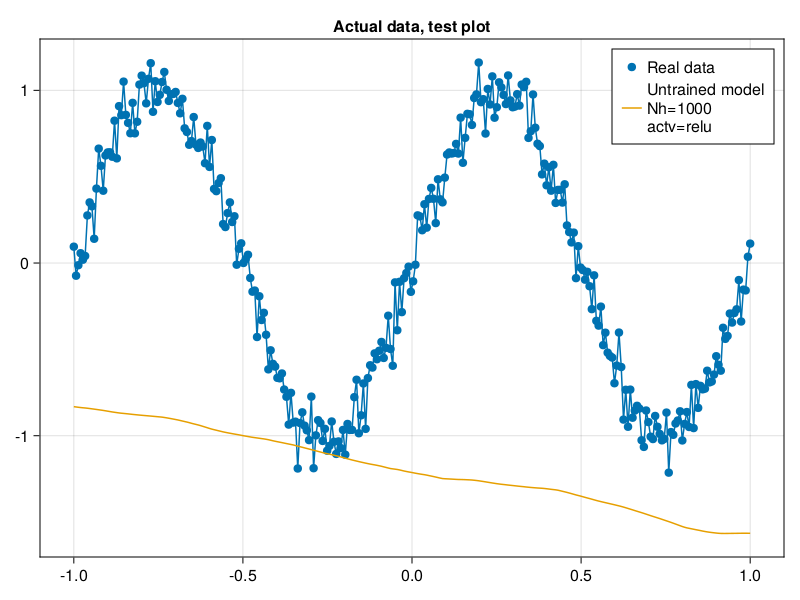

In [26]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1],title="Actual data, test plot")

CairoMakie.lines!(xVec[:], yVec[:])
CairoMakie.scatter!(xVec[:], yVec[:], label="Real data")

CairoMakie.lines!(xVec[:], model(hcat(xVec...))[:], label="Untrained model\nNh=$Nh\nactv=$act")

axislegend(ax1,position=:rt)
fig

<h1>Trektin</h1>

In [27]:
using Distributions

a = -1.0;
b = 1.0;
Nx = 400
IN = 10

# Generate random matrix with numbers from a to b (inclusive)
xTrekt = rand(Uniform(-1,1),IN,Nx)

10×400 Matrix{Float64}:
  0.840121    0.931933   0.988228  …   0.049532  -0.65884   -0.0940983
  0.960125    0.546525  -0.111641      0.835301   0.135167   0.277609
  0.704587   -0.338221   0.652701      0.251447   0.529935  -0.735341
 -0.0013788   0.760696   0.603772      0.369709  -0.96601   -0.0118125
  0.574154    0.568139   0.428827      0.206804   0.133673   0.899794
 -0.528816   -0.256311   0.294664  …  -0.670244   0.393487  -0.477022
 -0.788201    0.495019   0.582788      0.319016  -0.142305  -0.633238
 -0.103222   -0.626583   0.955825      0.505067  -0.413248   0.26444
 -0.520379    0.368134  -0.128961      0.289203  -0.666381  -0.18367
  0.0129403   0.661746  -0.423692     -0.705222   0.729828  -0.362268

In [28]:
OUT = 3
ACT = relu

trekt3 = Chain(DenseNTK(IN, 8, ACT), DenseNTK(8,7, ACT), DenseNTK(7,5,ACT), DenseNTK(5,OUT));

In [14]:
K_trekt3 = kernel(trekt3, xTrekt,true);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [16]:
eig_trekt3 = eig(K_trekt3)

3600-element Vector{Float64}:
   1.8915049293459438e-13
   1.0390594383807588e-13
   4.506610184051366e-14
   2.0687696484974222e-14
   3.777560306032694e-15
   1.7638690646105597e-15
   1.5960865581956153e-15
   1.2072810977926565e-15
   9.389149245272826e-16
   5.100313267918521e-16
   ⋮
   5.856475596566873
   7.908311637701482
   9.26592922345317
  11.433447129098315
  15.465062765505014
  24.341928802545315
  99.17127837764313
 506.5313666307698
 697.2340307270948

In [34]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10,title="Actual data, test plot")

CairoMakie.scatter!(eig_trekt3[:],label="H")


axislegend(ax1,position=:lt)
fig